## Pull In Fly Ball Data for a Given Date

In [132]:
fly_balls = {}

In [133]:
import datetime
import mlbapi
string_date = '2024-06-05'
base = datetime.date(int(string_date.split('-')[0]),
                     int(string_date.split('-')[1]),
                     int(string_date.split('-')[2]))
date_list = [base]
date_list

[datetime.date(2024, 6, 5)]

In [134]:
import time

count = 0 
fly_count = 0
for date_string in date_list:
    print(len(fly_balls))
    game_list = mlbapi.schedule(date=date_string).dates[0].games
    game_list = [x for x in game_list if ((x.status.detailed_state != 'Suspended') and (x.status.detailed_state != 'Postponed'))]
    if len(game_list) > 0:
        time.sleep(3)
        for game in game_list:
            plays = mlbapi.play_by_play(game.game_pk)
            for play in plays['allPlays']:
                if play['result']['event'] in ['Sac Fly', 'Forceout', 'Fielders Choice', 'Fielders Choice Out', 'Double Play', 'Single', 'Double', 'Triple', 'Field Error', 'Pop Out', 'Flyout', 'Lineout']:
                    if play['playEvents'][-1]['hitData']['trajectory'] != 'ground_ball':
                        try:
                            if play['playEvents'][-1]['hitData']['location'] in ['7','8','9']:
                                play_show = play['playEvents'][-1]['hitData']
                                play_show['results'] = play['result']['event']
                                play_show['x'] = play_show['coordinates']['coordX']
                                play_show['y'] = play_show['coordinates']['coordY']
                                play_show['hitter'] = play['matchup']['batter']['fullName']
                                i = play['result']['description']
                                if ': ' in i:
                                    i = i.replace(i.split(': ')[0]+': ', '')
                                if '.' in play_show['hitter']:
                                    i = i.replace(play_show['hitter'].replace('.', '.    '), play_show['hitter'])
                                    i = i.replace(play_show['hitter'].replace('.', '.   '), play_show['hitter'])
                                    i = i.replace(play_show['hitter'].replace('.', '.  '), play_show['hitter'])
                                    i = i.replace(play_show['hitter'].replace('.', '. '), play_show['hitter'])
                                if '  ' in i:
                                    i = i.split('  ')[0]    
                                if 'deflected' in i:
                                    i = i.split(', deflected')[0]
                                i = i.replace('Jr.flies', 'Jr. flies')
                                i = i.replace('Jr.pops', 'Jr. pops')
                                i = i.replace('Jr.lines', 'Jr. lines')
                                i = i.replace('Jr.singles', 'Jr. singles')
                                i = i.replace('Jr.doubles', 'Jr. doubles')
                                i = i.replace('Jr.triples', 'Jr. triples')
                                i = i.replace('Jr.reaches', 'Jr. reaches')
                                i = i.replace('Sr.flies', 'Sr. flies')
                                i = i.replace('Sr.pops', 'Sr. pops')
                                i = i.replace('Sr.lines', 'Sr. lines')
                                i = i.replace('Sr.singles', 'Sr. singles')
                                i = i.replace('Sr.doubles', 'Sr. doubles')
                                i = i.replace('Sr.triples', 'Sr. triples')
                                i = i.replace('Sr.reaches', 'Sr. reaches')
                                play_show['description'] = i
                                play_show['inning'] = play['about']['inning']
                                play_show['halfInning'] = play['about']['halfInning']
                                if play_show['halfInning'] == 'top':
                                    play_show['away_score'] = play['result']['awayScore'] - play['result']['rbi']
                                    play_show['home_score'] = play['result']['homeScore']
                                else:
                                    play_show['away_score'] = play['result']['awayScore']
                                    play_show['home_score'] = play['result']['homeScore'] - play['result']['rbi']
                                play_show['playId'] = play['playEvents'][-1]['playId']
                                play_show['stadium'] = game.teams.home.team.name
                                play_show['away_team'] = game.teams.away.team.name
                                play_show['outs'] = play['count']['outs']
                                play_show['date'] = string_date
                                play_show['hitter'] = play['matchup']['batter']['link'].split('/')[-1]
                                for fi in range(len(play['runners'])):
                                    try:
                                        play_show['fielder'] = play['runners'][fi]['credits'][0]['player']['link'].split('/')[-1]
                                    except:
                                        continue
                                fly_count += 1
                                fly_balls[fly_count] = play_show
                        except:
                            continue

0
https://statsapi.mlb.com/api/v1/schedule {'date': datetime.date(2024, 6, 5), 'sportId': 1}


In [135]:
import pandas as pd

dff = pd.DataFrame.from_dict(fly_balls, orient='index')
plays = dff.copy()
plays.head()

,launchSpeed,launchAngle,totalDistance,trajectory,hardness,location,coordinates,results,x,y,...,inning,halfInning,away_score,home_score,playId,stadium,away_team,outs,date,fielder
1,100.8,18.0,351.0,line_drive,medium,8,"{'coordX': 96.79, 'coordY': 57.08}",Double,96.79,57.08,...,2,bottom,0,1,1eeb7f69-9f86-41c0-b4a6-f8ae78f7dba6,Boston Red Sox,Atlanta Braves,0,2024-06-05,671739
2,96.4,60.0,202.0,fly_ball,medium,7,"{'coordX': 105.1, 'coordY': 122.75}",Flyout,105.10,122.75,...,2,bottom,0,2,b29dc61d-0a1f-4877-a69f-035f471643fc,Boston Red Sox,Atlanta Braves,1,2024-06-05,672284
3,86.9,31.0,306.0,fly_ball,medium,7,"{'coordX': 89.98, 'coordY': 81.74}",Sac Fly,89.98,81.74,...,2,bottom,0,2,ea5967b3-3067-44b6-87bf-d0600742bf0e,Boston Red Sox,Atlanta Braves,2,2024-06-05,672284
4,101.6,16.0,284.0,line_drive,hard,8,"{'coordX': 156.13, 'coordY': 70.04}",Single,156.13,70.04,...,3,bottom,0,3,8fb98534-fb82-49a4-adc3-bae7ff0dbc3a,Boston Red Sox,Atlanta Braves,1,2024-06-05,671739
5,71.9,28.0,207.0,fly_ball,medium,9,"{'coordX': 190.18, 'coordY': 129.23}",Single,190.18,129.23,...,4,top,0,3,cffd8727-5e06-41c8-8f12-bda2558c00b6,Boston Red Sox,Atlanta Braves,0,2024-06-05,641933


## Calculate Catch Probability from Saved Model

In [136]:
import pickle
import math
with open('model5.pkl', 'rb') as f:
    logisticRegr = pickle.load(f)
dff = dff[dff['launchSpeed'].notna()]
dff = dff[dff['launchAngle'].notna()].reset_index(drop=True)
dff['launchAngle'] = dff['launchAngle'].astype(float)
dff['launchSpeed'] = dff['launchSpeed'].astype(float)
dff['launchSpeed_og'] = dff['launchSpeed'].copy()
dff['launchSpeed'] = dff['launchSpeed'] * .44704
time_list = []
for i in range(len(dff)):
    time_list.append((dff['launchSpeed'][i]*math.sin(dff['launchAngle'][i]*(math.pi/180))+math.sqrt((dff['launchSpeed'][i]*math.sin(dff['launchAngle'][i]*(math.pi/180)))**2 + (2 * 9.8 * 1))) / 9.8)
dff2 = pd.read_csv('22_input.csv')
centroids = dff2.groupby(['stadium', 'location'])[['x', 'y']].mean().reset_index()
centroid_map_x = dict(zip(centroids['stadium']+centroids['location'].astype(str), centroids['x']))
centroid_map_y = dict(zip(centroids['stadium']+centroids['location'].astype(str), centroids['y']))
dff['hang_time'] = time_list
dff['out'] = 1
dff.loc[dff['results'].isin(['Single', 'Double', 'Triple', 'Field Error']), 'out'] = 0
dff['centroid_x'] = (dff['stadium']+dff['location'].astype(str)).map(centroid_map_x)
dff['centroid_y'] = (dff['stadium']+dff['location'].astype(str)).map(centroid_map_y)
distance_list = []
for i in range(len(dff)):
    distance_list.append( math.sqrt(  (dff['centroid_x'][i]-dff['x'][i])**2  + (dff['centroid_y'][i]-dff['y'][i])**2))
dff['distance'] = distance_list
dff = dff[dff['hang_time'].notna()]
dff = dff[dff['distance'].notna()]
dff['catch_odds'] = logisticRegr.predict_proba(dff[['distance', 'hang_time']])[::, 1]
plays = dff.copy()

C:\Users\btmyr\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [137]:
all_plays = [[x, plays.loc[x]['description'], plays.loc[x]['catch_odds']] for x in range(len(plays))]
all_plays = pd.DataFrame(all_plays, columns = ['key', 'description', 'catch_odds'])
all_plays

,key,description,catch_odds
0,0,David Hamilton doubles (5) on a line drive to ...,0.22
1,1,Ceddanne Rafaela flies out to left fielder Jar...,0.98
2,2,Reese McGuire out on a sacrifice fly to left f...,0.92
3,3,Rob Refsnyder singles on a sharp line drive to...,0.23
4,4,Austin Riley singles on a fly ball to right fi...,0.50
...,...,...,...
282,282,Josh Rojas flies out to right fielder Daz Came...,0.99
283,283,Cal Raleigh flies out to center fielder JJ Ble...,0.98
284,284,J.D. Davis singles on a sharp line drive to le...,0.05
285,285,J.P. Crawford flies out to center fielder JJ B...,0.94


In [141]:
key = 23
all_plays[all_plays['key'] == key]

,key,description,catch_odds
23,23,Jon Singleton lines out to right fielder Alec ...,0.84


C:\Users\btmyr\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\btmyr\AppData\Local\Temp\ipykernel_28264\2696044272.py:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(["{:.1%}".format(i) for i in cb.get_ticks()], fontsize=16, weight='bold')


Jon Singleton lines out to right fielder Alec Burleson. (2024-06-05)
https://baseballsavant.mlb.com/sporty-videos?playId=5552170b-6611-4ad2-8c7c-77a2055ce048


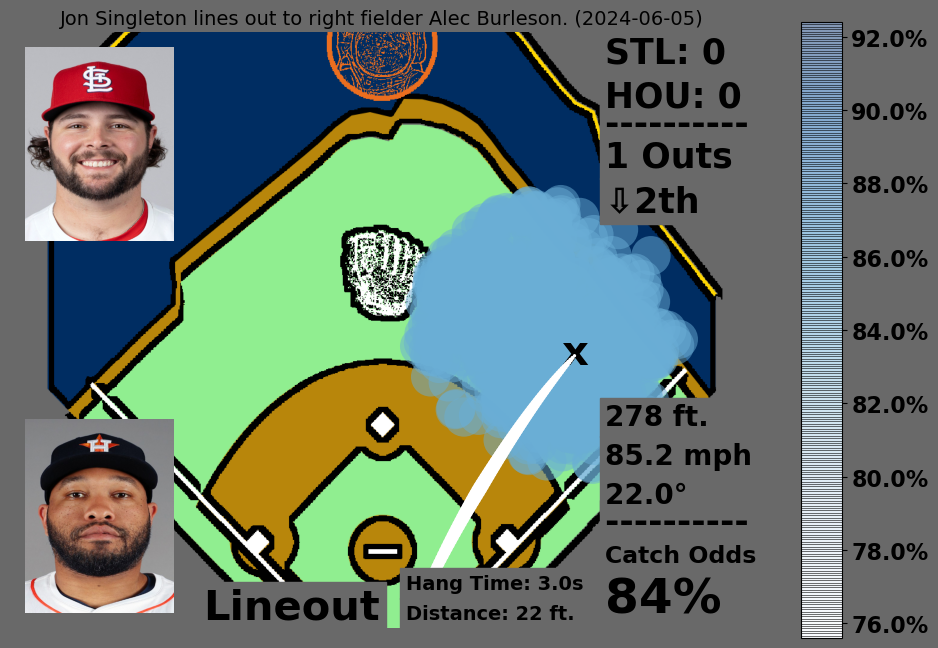

In [143]:
import numpy as np
from PIL import Image
from scipy import interpolate
import matplotlib.pyplot as plt
import requests

tm_abbrev = {}
tm_abbrev['Pittsburgh Pirates'] = 'PIT'
tm_abbrev['Washington Nationals'] = 'WSH'
tm_abbrev['Toronto Blue Jays'] = 'TOR'
tm_abbrev['Boston Red Sox'] = 'BOS'
tm_abbrev['Baltimore Orioles'] = 'BAL'
tm_abbrev['Philadelphia Phillies'] = 'PHI'
tm_abbrev['Tampa Bay Rays'] = 'TB'
tm_abbrev['Miami Marlins'] = 'MIA'
tm_abbrev['Cincinnati Reds'] = 'CIN'
tm_abbrev['Kansas City Royals'] = 'KC'
tm_abbrev['Chicago White Sox'] = 'CHW'
tm_abbrev['Texas Rangers'] = 'TEX'
tm_abbrev['Colorado Rockies'] = 'COL'
tm_abbrev['Arizona Diamondbacks'] = 'ARI'
tm_abbrev['Minnesota Twins'] = 'MIN'
tm_abbrev['Oakland Athletics'] = 'OAK'
tm_abbrev['Los Angeles Dodgers'] = 'LAD'
tm_abbrev['New York Yankees'] = 'NYY'
tm_abbrev['San Diego Padres'] = 'SD'
tm_abbrev['Atlanta Braves'] = 'ATL'
tm_abbrev['Houston Astros'] = 'HOU'
tm_abbrev['Chicago Cubs'] = 'CHC'
tm_abbrev['Milwaukee Brewers'] = 'MIL'
tm_abbrev['Seattle Mariners'] = 'SEA'
tm_abbrev['Los Angeles Angels'] = 'LAA'
tm_abbrev['Detroit Tigers'] = 'DET'
tm_abbrev['Cleveland Guardians'] = 'CLE'
tm_abbrev['San Francisco Giants'] = 'SF'
tm_abbrev['New York Mets'] = 'NYM'
tm_abbrev['St. Louis Cardinals'] = 'STL'

example = plays.loc[key]
hit_speed = 99 * 0.44704
hit_speed = example['launchSpeed']
playId = example['playId']
hit_angle = example['launchAngle']
description = example['description']+' ('+example['date']+')'
hit_location = example['location']
hitter = example['hitter']
fielder = example['fielder']
outs = str(example['outs'])
inning = example['halfInning'].replace('top', '⇧').replace('bottom', '⇩')+str(example['inning'])+'th'
stadium = example['stadium']
result_play = example['results']
x = example['x']
y = example['y']
away_team = tm_abbrev[example['away_team']]
home_team = tm_abbrev[example['stadium']]
away_score = example['away_score']
home_score = example['home_score']
if x == 125:
    x = 124.97
max_h = (((hit_speed**2)*(math.sin(hit_angle*(math.pi/180))**2))/19.6)+1
mid_x = (125+x)/2
mid_y = (222+y)/2 - max_h
end_x = 125
end_y = 220
x2 = np.linspace(x, end_x, 100)
if (x < mid_x) & (mid_x < end_x):
    y2 = interpolate.pchip_interpolate([x,mid_x,end_x], [y, mid_y, end_y], x2)
elif (x > mid_x) & (mid_x > end_x):
    y2 = interpolate.pchip_interpolate([end_x,mid_x,x], [end_y, mid_y, y], x2)
x2 = np.linspace(x, end_x, 100)
z2 = np.linspace(0, max_h*8, 50)
array2 = np.linspace(max_h*8, 0, 50)

# Appending both arrays using Append method
z2 = np.append(z2, array2)
hit_hang = (hit_speed*math.sin(hit_angle*(math.pi/180))+math.sqrt((hit_speed*math.sin(hit_angle*(math.pi/180)))**2 + (2 * 9.8 * 1))) / 9.8
hit_x = x
hit_y = y
hit_dist = math.sqrt(  (centroid_map_x[stadium+str(hit_location)]-x)**2  + (centroid_map_y[stadium+str(hit_location)]-y)**2)
catch_odds = logisticRegr.predict_proba(np.array((hit_dist,hit_hang)).reshape(1,-1))[0][1]

catchy = round(catch_odds*100,1)
if example['out'] == 1:
    if catchy < 20:
        emojis = '💎💎💎💎💎'
    elif catchy < 40:
        emojis = '💎💎💎💎'
    elif catchy < 60:
        emojis = '💎💎💎'
    elif catchy < 80:
        emojis = '💎💎'
    elif catchy <= 100:
        emojis = '🌽'
elif example['out'] == 0:
    if catchy > 80:
        emojis = '🍀🍀🍀🍀🍀'
    elif catchy > 60:
        emojis = '🍀🍀🍀🍀'
    elif catchy > 40:
        emojis = '🍀🍀🍀'
    elif catchy > 20:
        emojis = '🍀🍀'
    elif catchy >= 0:
        emojis = '💥'

dff2 = pd.read_csv('22_input.csv')
df_filter = dff2[dff2['stadium'] == stadium].reset_index(drop=True)
distances = []
locations = []
xs = []
ys = []
for location in df_filter['location'].unique().tolist():
    x = centroid_map_x[dff2['stadium'][0]+str(location)]
    y = centroid_map_y[dff2['stadium'][0]+str(location)]
    for i in range(len(df_filter)):
        xs.append(dff2['x'][i])
        ys.append(dff2['y'][i])
        locations.append(location)
        distances.append(math.sqrt(  (x-dff2['x'][i])**2  + (y-dff2['y'][i])**2))

df_show = pd.DataFrame(columns = ['distances'], data = distances)
df_show['hang_time'] = hit_hang
df_show['location'] = locations
df_show['x'] = xs
df_show['y'] = ys
df_show['catch_odds'] = example['catch_odds']
df_show = df_show.sort_values(by='catch_odds')
if hit_hang <= 3.5:
    df_show = df_show[df_show['distances'] < 45]
else:
    df_show = df_show[df_show['distances'] < 70]

img = Image.open(requests.get('https://raw.githubusercontent.com/Melverk/bsbl-images/main/fields/'+home_team.upper()+'.png', stream=True).raw)
image_link = 'https://img.mlbstatic.com/mlb-photos/image/upload/d_people:generic:headshot:67:current.png/w_500,q_auto:best/v1/people/'+str(fielder)+'/headshot/67/current'
img2 = Image.open(requests.get(image_link, stream=True).raw).convert('RGBA')
image_link3 = 'https://img.mlbstatic.com/mlb-photos/image/upload/d_people:generic:headshot:67:current.png/w_500,q_auto:best/v1/people/'+str(hitter)+'/headshot/67/current'
img3 = Image.open(requests.get(image_link3, stream=True).raw).convert('RGBA')
fig, ax = plt.subplots( figsize =(12, 10), facecolor='dimgray')
im = ax.scatter(df_show[df_show['location'] == int(hit_location)]['x'], df_show[df_show['location'] == int(hit_location)]['y'], c = df_show[df_show['location'] == int(hit_location)]['catch_odds'], cmap= 'Blues', linewidths = 0, s=800, alpha=0.5)


plt.text(hit_x-5, hit_y+3.5, "x", fontsize = 30, fontweight = 'bold', color = 'black')
plt.text(200, 34, '----------  ', fontsize = 25, fontweight = 'bold', color = 'black', backgroundcolor='dimgray')
plt.text(200, 10, away_team+': '+str(away_score)+'    ', fontsize = 25, fontweight = 'bold', color = 'black', backgroundcolor='dimgray')
plt.text(200, 25, home_team+': '+str(home_score)+'    ', fontsize = 25, fontweight = 'bold', color = 'black', backgroundcolor='dimgray')
plt.text(200, 45, outs+' Outs      ', fontsize = 25, fontweight = 'bold', color = 'black', backgroundcolor='dimgray')
plt.text(200, 60, inning+'       ', fontsize = 25, fontweight = 'bold', color = 'black', backgroundcolor='dimgray')
im2 = ax.scatter(x2, y2, color='white', s = z2, zorder=4)

plt.text(133, 187, 'Hang Time: '+str(round(hit_hang,1))+'s', fontsize = 14, fontweight = 'bold', color = 'black', backgroundcolor = 'dimgray', zorder =5)
plt.text(133, 197, 'Distance: '+str(int(example['distance']*2.192))+' ft.', fontsize = 14, fontweight = 'bold', color = 'black', backgroundcolor = 'dimgray', zorder =5)

plt.text(65, 197, result_play, fontsize = 30, fontweight = 'bold', color = 'black', backgroundcolor = 'dimgray', zorder =5)

plt.text(200, 168, '----------  ', fontsize = 25, fontweight = 'bold', color = 'black', backgroundcolor='dimgray')
try:
    plt.text(200, 132, str(int(example['totalDistance']))+' ft.   ', fontsize = 20, fontweight = 'bold', color = 'black', backgroundcolor='dimgray')
except:
    plt.text(200, 132, '? ft.   ', fontsize = 20, fontweight = 'bold', color = 'black', backgroundcolor='dimgray')
plt.text(200, 145, str(round(hit_speed/.44704,1))+' mph   ', fontsize = 20, fontweight = 'bold', color = 'black', backgroundcolor='dimgray')
plt.text(200, 158, str(round(hit_angle,1))+'°        ', fontsize = 20, fontweight = 'bold', color = 'black', backgroundcolor='dimgray')
plt.text(200, 178, 'Catch Odds    ', fontsize = 17, fontweight = 'bold', color = 'black', backgroundcolor='dimgray')
if int(catch_odds*100) != 100:
    plt.text(200, 195, str(int(catch_odds*100))+'%      ', fontsize = 35, fontweight = 'bold', color = 'black', backgroundcolor='dimgray')
else:
    plt.text(200, 195, str(100)+'%      ', fontsize = 35, fontweight = 'bold', color = 'black', backgroundcolor='dimgray')

plt.imshow(img,zorder=0, extent=[-20,270,250,-50])
plt.imshow(img2,zorder=1, extent=[5,55,70,5], )
plt.imshow(img3,zorder=1, extent=[5,55,195,130])
ax.set_ylim(200, 0)
ax.set_xlim(0,250)
ax.set_xticks([])
ax.set_yticks([])
plt.title(description, fontsize=14)
cb =fig.colorbar(im, ax=ax, shrink=0.8, aspect=15,  drawedges='N', )
cb.ax.set_yticklabels(["{:.1%}".format(i) for i in cb.get_ticks()], fontsize=16, weight='bold')
print(description)
print('https://baseballsavant.mlb.com/sporty-videos?playId='+playId)
plt.axis('off')
plt.show()